# CSCA 5622 Introduction to Machine Learning Supervised Learning Week 7 Final Project

## Project Topic

**Project focus**: This project intends to use customer attributes to predict customer churn. 

**Type of learning**: This is a typical supervised learning problem.

**Type of task**: Our task is classification, given that customer churn is a yes/no outcome. 

**Importance**: Predicting customer churn has significant business importance. If a company can predict customer churn with reasonable accuracy, the company will be able to implement customer retention actions and therefore prevent revenue reduction. 

**Goal**: We would like to analyze relevant customer data and develop focused customer retention programs.

## Packages

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
      
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

np.random.seed(0)

## Data

**Source**: This dataset is a public dataset published on Kaggle at https://www.kaggle.com/datasets/blastchar/telco-customer-churn.

**Provenance**: The dataset contains information about a fictional telecommunication company that provides home phone and Internet services to customers. It indicates which customers have left or stayed. Multiple demographics are included for each customer, as well as the services the customer signed up for.

In [2]:
working_dir = "/home/lee/Documents/csca5622week7/"
df = pd.read_csv(os.path.join(working_dir, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

### Data size

In [3]:
print(f"data size: {df.size}")
print(f"number of rows: {df.shape[0]}")
print(f"number of columns: {df.shape[1]}")

data size: 147903
number of rows: 7043
number of columns: 21


### Data preview

In [4]:
print(f"preview: \n{df.head()}")

preview: 
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Con

### Column data type

In [5]:
print(f"data type: \n{df.dtypes}")

data type: 
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


## Data Cleaning

Here we perform data cleaning. We will change the data types to what are appropriate, investigate missing data, impute missing data if necessary, and check for class imbalance. 

### Reindexing

Are the rows uniquely indexed by customerID?

In [6]:
# Step 1: Group by customer id and count occurrences
customer_counts = df.groupby('customerID').size()

# Step 2: Filter customer id's with more than one occurrence
duplicate_customers = customer_counts[customer_counts > 1]
print(f'number of customers with more than one row of records in the dataset: {len(duplicate_customers)}')

del customer_counts, duplicate_customers 

number of customers with more than one row of records in the dataset: 0


Yes, they are - let's set customer id to be the row index.

In [7]:
df.set_index('customerID', inplace=True)

### Data type munging

We earlier showed the data types of the columns. We notice that `TotalCharges` is not recognized as a numeric column. Let's investigate this issue.

In [8]:
TotalCharges = df['TotalCharges'].copy()
TotalCharges = TotalCharges.str.replace('.', '')
print(df[TotalCharges.str.isnumeric() == False])
del TotalCharges

            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
4472-LVYGI  Female              0     Yes        Yes       0           No   
3115-CZMZD    Male              0      No        Yes       0          Yes   
5709-LVOEQ  Female              0     Yes        Yes       0          Yes   
4367-NUYAO    Male              0     Yes        Yes       0          Yes   
1371-DWPAZ  Female              0     Yes        Yes       0           No   
7644-OMVMY    Male              0     Yes        Yes       0          Yes   
3213-VVOLG    Male              0     Yes        Yes       0          Yes   
2520-SGTTA  Female              0     Yes        Yes       0          Yes   
2923-ARZLG    Male              0     Yes        Yes       0          Yes   
4075-WKNIU  Female              0     Yes        Yes       0          Yes   
2775-SEFEE    Male              0      No        Yes       0          Yes   

### Imputing missing data

We can see that all these customers have a tenure of 0. Looks like they are all brand new customers and have not paid any bills yet. Therefore we decide to set their `TotalCharges` to 0. 

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Let's use visualization to see whether setting the missing `TotalCharges` to 0 significantly changes the distribution of this variable. 

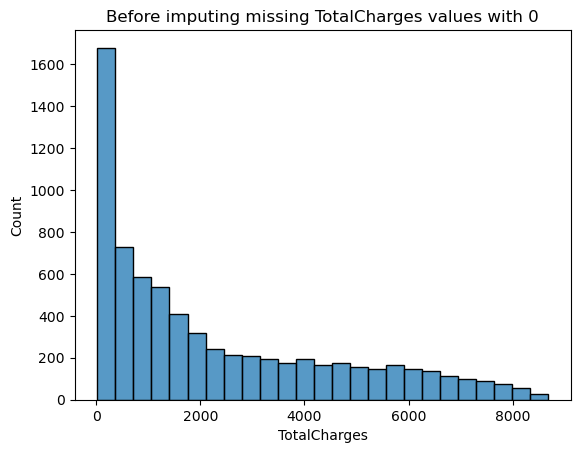

In [10]:
sns.histplot(data=df, x='TotalCharges').set_title("Before imputing missing TotalCharges values with 0")
plt.show()

In [11]:
df['TotalCharges'].fillna(0, inplace=True)

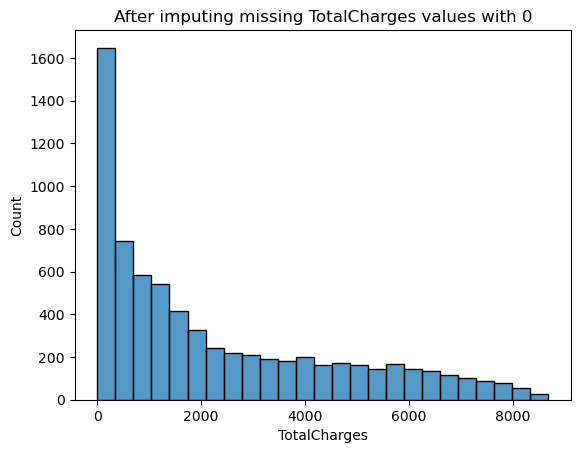

In [12]:
sns.histplot(data=df, x='TotalCharges').set_title("After imputing missing TotalCharges values with 0")
plt.show()

### Missing data checking

Now we continue to check for missing data in other columns.

In [13]:
print(f"columns with at least 1 NaN value: \n{df.columns[df.isna().any()].tolist()}")

columns with at least 1 NaN value: 
[]


No other missing data to handle. 

### Class (im)balance checking

In [14]:
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True))

Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


The two classes of the target are well balanced. 

### Data cleaning summary

It appears that this dataset is mostly clean. Not a whole lot of data preprocessing needs to be done to address dirty data. However, we likely still need to transform or encode data before we start modeling. We will decide such data preprocessing actions after we review EDA results. 

## Exploratory Data Analysis

Looking at the customer attributes, only `tenure`, `MonthlyCharges`, and `TotalCharges` are continuous. The rest are all categorical. 

In [15]:
# group features to groups, continuous and categorical
columns_all = tuple(df.columns)

continuous_features_set = set(('tenure', 'MonthlyCharges', 'TotalCharges'))
continuous_features = tuple(col for col in columns_all if (col in continuous_features_set) == True)

categorical_features_set = set(columns_all) - continuous_features_set - set(['Churn'])
categorical_features = tuple(col for col in columns_all if (col in categorical_features_set) == True)

binary_features_set = set(('gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'))
binary_features = tuple(col for col in columns_all if (col in binary_features_set) == True)

non_binary_features_set = categorical_features_set - binary_features_set
non_binary_features = tuple(col for col in columns_all if (col in non_binary_features_set) == True)

del continuous_features_set, categorical_features_set, binary_features_set, non_binary_features_set

### Summary statistics

In [16]:
for feature in categorical_features:
    print(df[feature].value_counts(dropna=False))
    print('\n')

gender
Male      3555
Female    3488
Name: count, dtype: int64


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


TechSupport
No                     3473
Yes                    2044
No internet ser

In [17]:
for feature in continuous_features:
    print(df[feature].describe())
    print('\n')

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64




### Visualization

### Histogram, boxplot, scatterplot for continuous variables

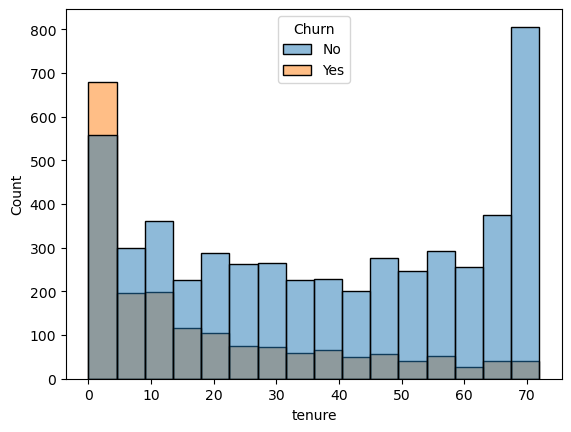

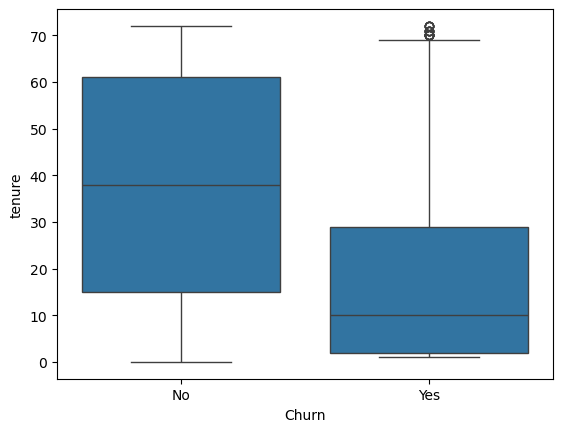

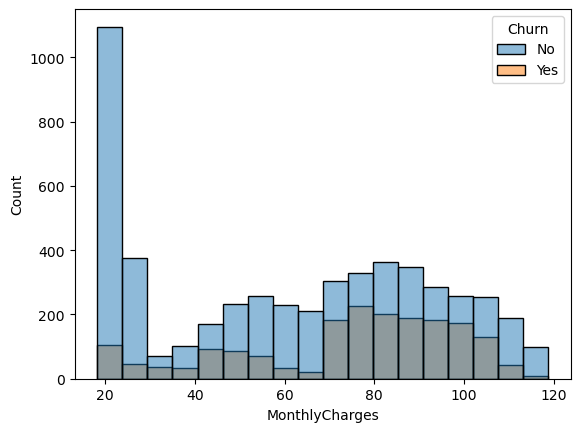

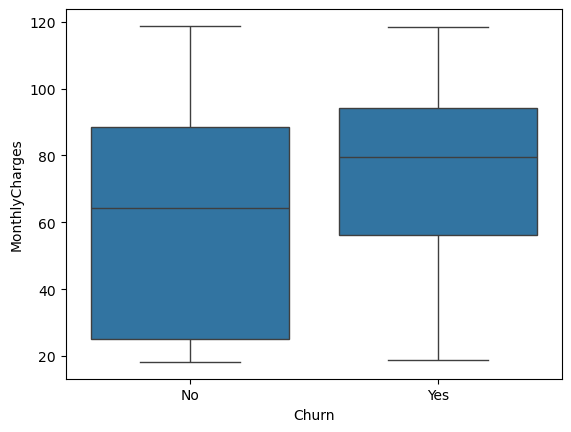

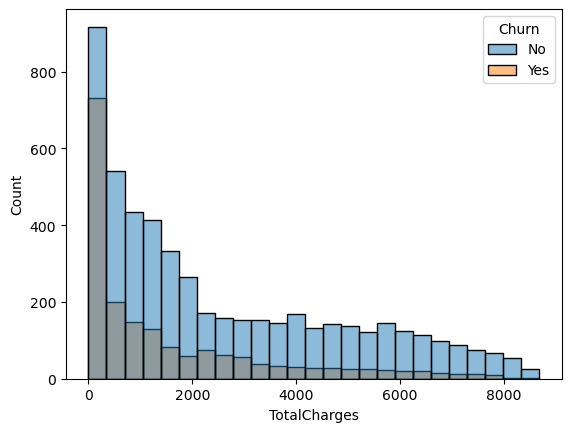

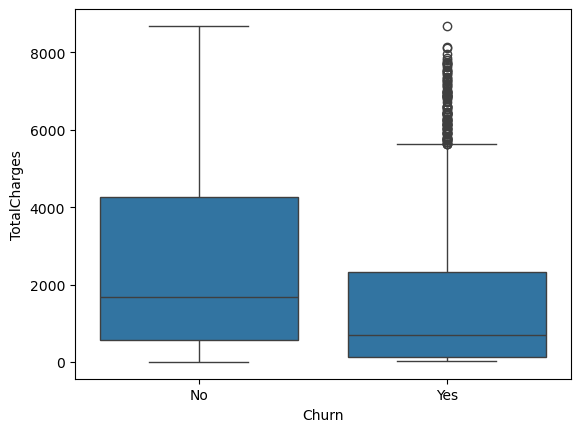

In [18]:
for feature in continuous_features:
    sns.histplot(data=df, x=feature, hue='Churn')
    plt.show()
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.show()

### Correlations

#### Correlation matrix

<Axes: >

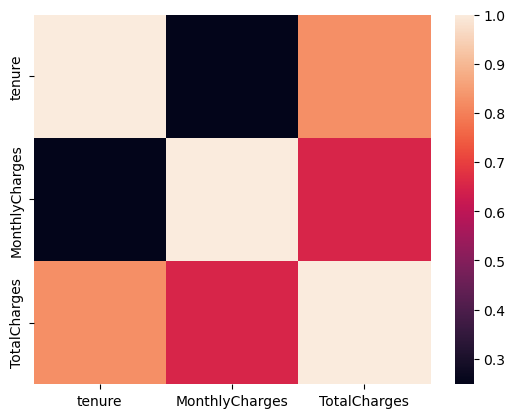

In [19]:
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr())

#### Statistical tests

Use Spearman's correlation to look at the relationship between customer tenure and monthly charge. 

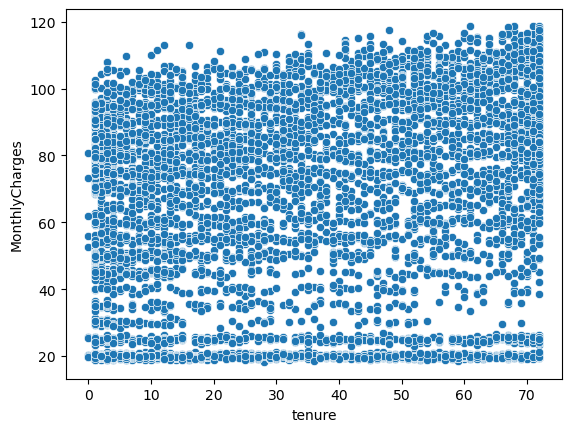

Spearman's correlation coefficient: 0.2764


In [20]:
sns.scatterplot(data=df, y="MonthlyCharges", x="tenure")
plt.show()
print(f"Spearman's correlation coefficient: {df[['MonthlyCharges', 'tenure']].corr(method='spearman').loc['MonthlyCharges', 'tenure']:0.4f}")

### Bar chart, for categorical variables

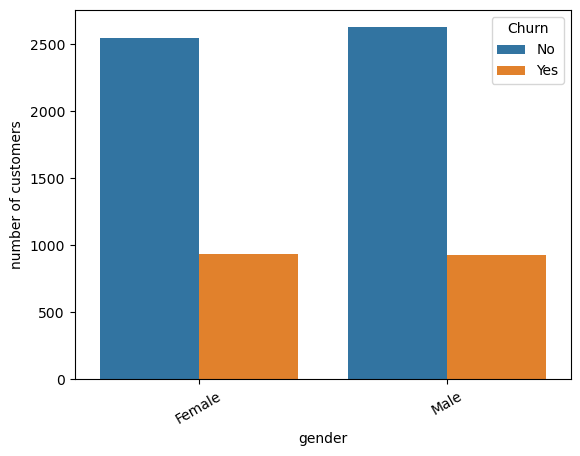

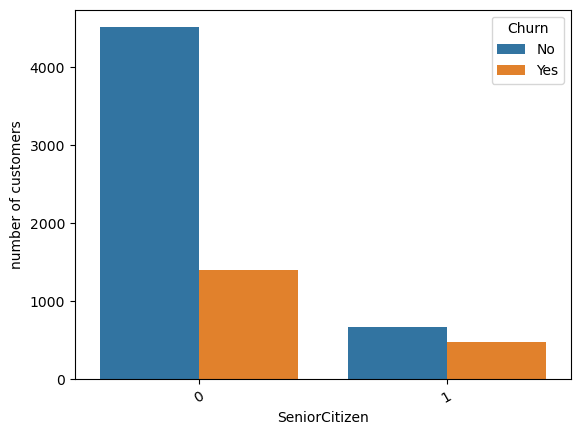

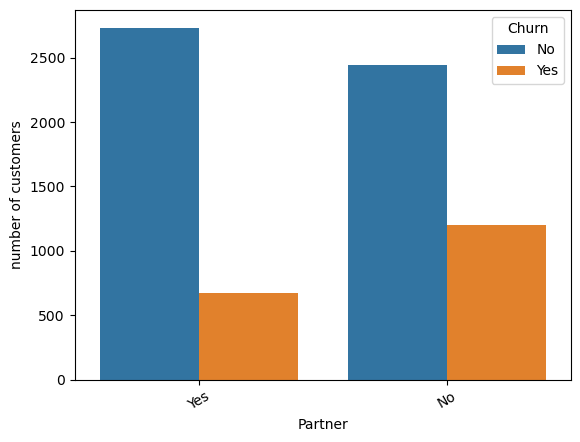

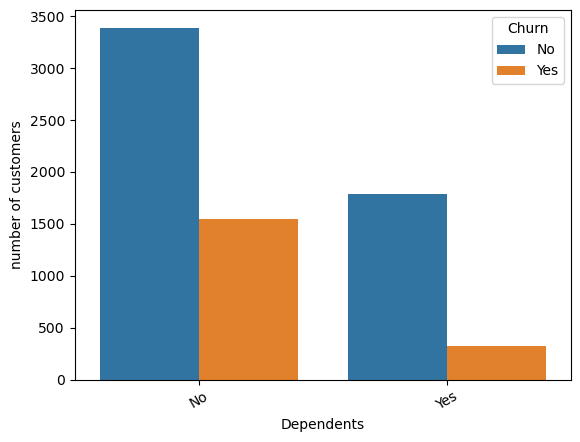

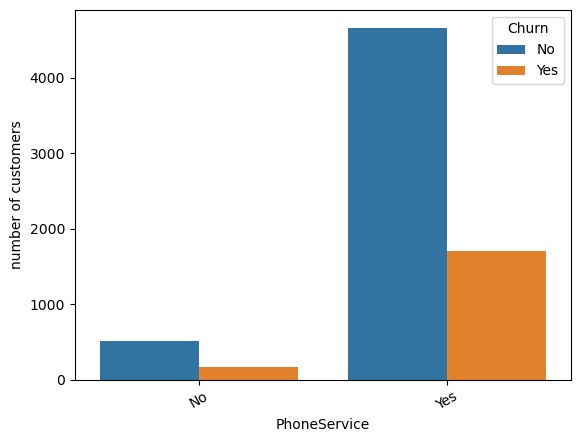

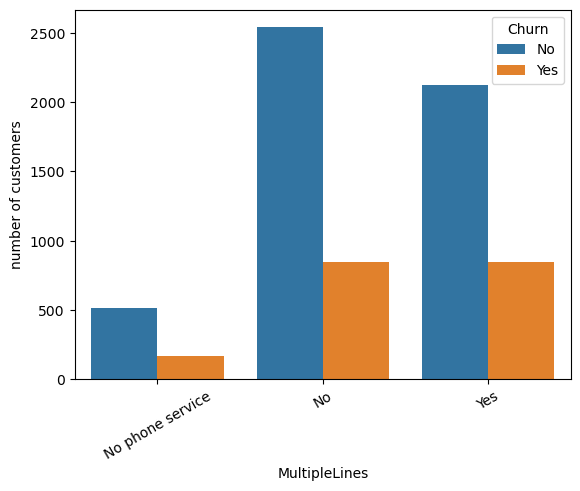

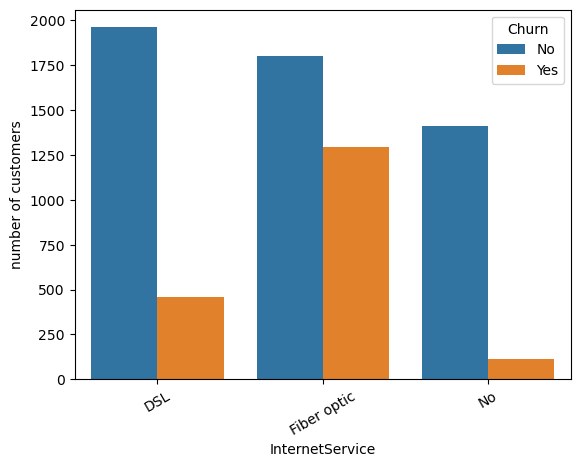

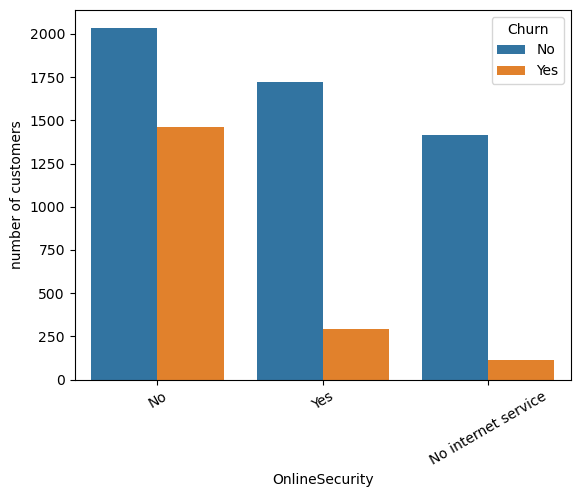

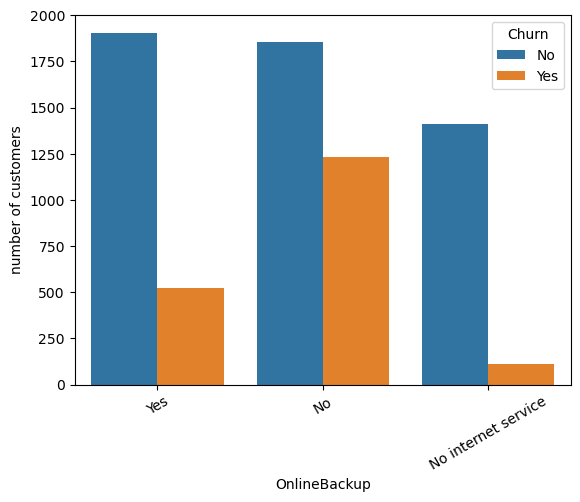

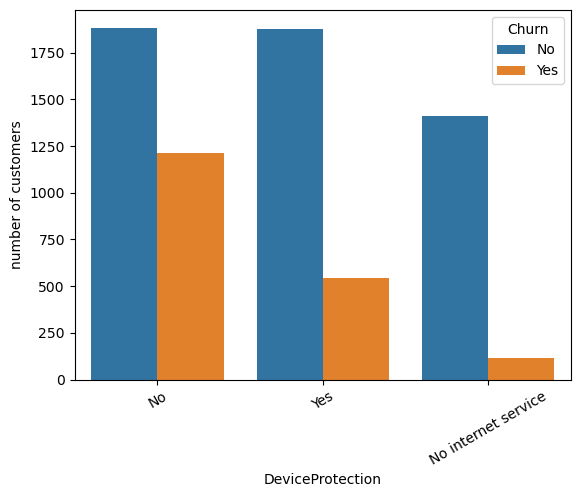

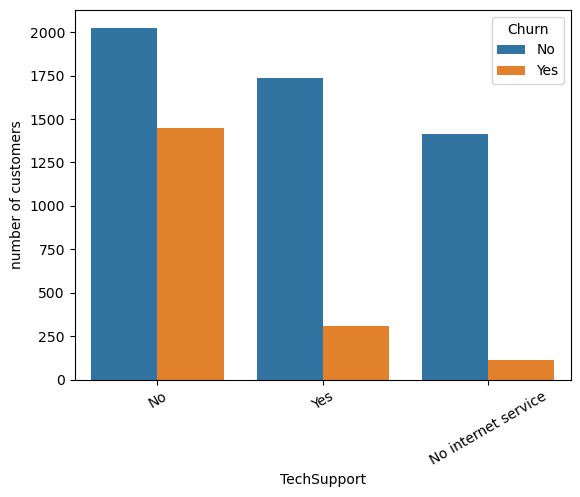

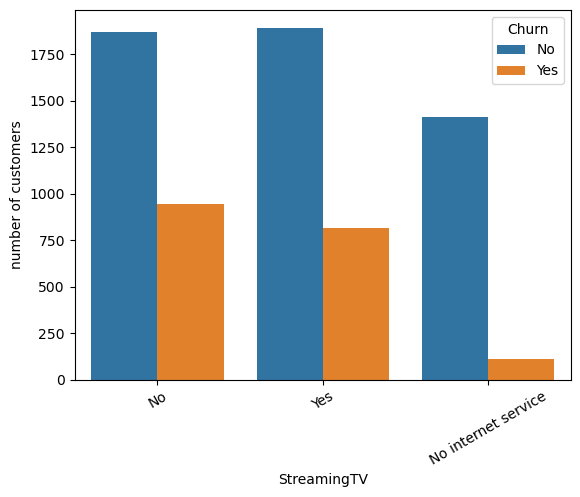

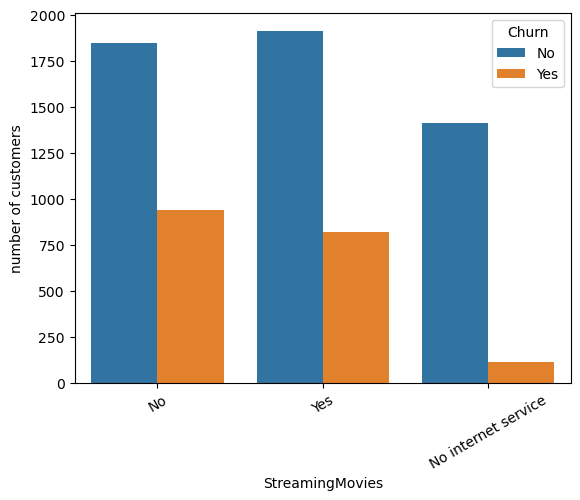

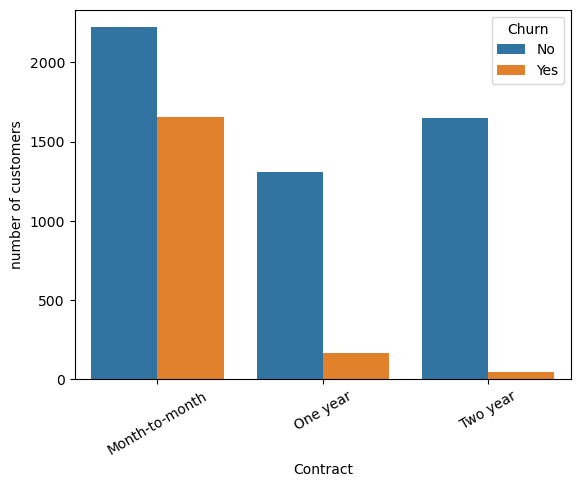

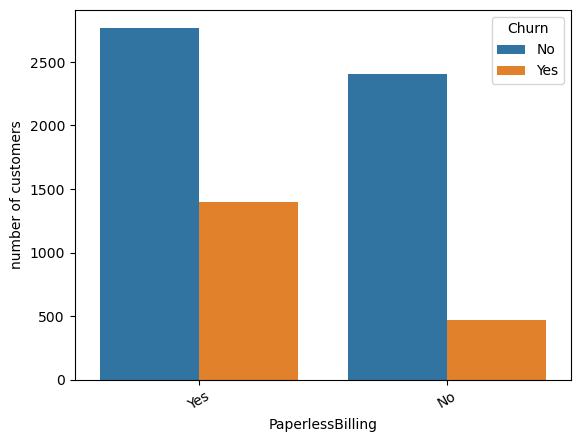

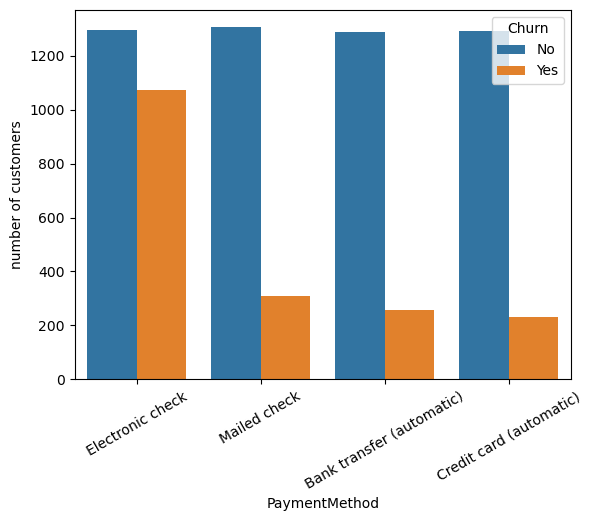

In [21]:
for feature in categorical_features:
    sns.countplot(x=feature, hue="Churn", data=df)
    plt.ylabel('number of customers')
    plt.xticks(rotation=30)
    plt.show()

### EDA conclusions

* Senior citizens appear to churn more. Does this mean our service is not friendly to senior citizens?
* Fiber optic users churn more. Is our fiber optic service unsatisfying?
* Among customers with internet service, having online security makes them less likely to churn. 
* Customers that pay with electronic check churn more - even more than the customers that go through the inconvenience of mailing in a check. Is our payment system functioning as expected here? 
* It is expected that customers that are on longer-term contracts are less likely to churn. But are we providing satisfying services to our month-to-month customers?
* I find it reasonable to assume 1) most the dependents are children that live with their parents and 2) their user satisfaction factors into the parents' decision whether to continue using our services. Looks like we are serving our young users well.
* Both `tenure` and `TotalCharges` are right censored: for a currently active member, we will not observe their lifetime total charges until when they actually cancel the service. The distributions of these features in the "Churn=No" group themselves do not give us much information other than a lower bound. However, there is insight when we look at all three boxplots together. Churned customers have higher monthly charges. Their tenure is substantially shorter than that of the active customers, but their total charges are quite high - approximately the same range with that of the active members. Churned customer also have a number of extremely high total charges. 

## Modeling

### Feature engineering

We have performed basic data cleaning and reindexing during EDA. Now we continue with the data preprocessing procedure to make the data suitable for the subsequent modeling process.

### Label encoding

We first encode the target labels.

The `LabelEncoder` class in scikit-learn can be used to normalize labels. In our use case, it functions the same as one-hot encoding.

In [22]:
lb = LabelEncoder()
df['Churn'] = lb.fit_transform(df['Churn'])

### One-hot encoding

One-hot encoding is a technique in machine learning that turns categorical data, like colors (red, green, blue), into numerical data for machines to understand. It creates new binary columns for each category, with a 1 marking the presence of that category and 0s elsewhere. This allows machine learning algorithms to process the information in categorical data without misinterpreting any order between the categories.

The dataset contains multiple categorical, string columns; we need to convert them to numeric values before being able to use them as model features. We apply one-hot encoding to the categorical features. 

In [23]:
cat_transformed = pd.get_dummies(df.drop(columns=['Churn']))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(cat_transformed, df['Churn'], test_size=0.2, random_state=0)

### Random forest model

We first fit a random forest classification model. 

#### Approach explanation

Random Forest algorithm is a powerful decision tree learning technique. It works by creating a number of decision trees during the training phase. Each tree is constructed using a random subset of the data set to measure a random subset of features in each partition. This randomness introduces variability among individual trees, reducing the risk of overfitting and improving overall prediction performance. When making predictions, the algorithm aggregates the results of all trees, either by voting (for classification tasks, which is our case) or by averaging (for regression tasks). This collaborative decision-making process, supported by multiple trees with their insights, provides an example stable and precise results. Random Forest models are well known for their ability to handle complex data, reduce overfitting, and provide reliable forecasts in different environments.

#### Reasoning

Random forest is often the first algorithm we try due to its many advantages.

It has high accuracy. Using several decision trees, each trained on a distinct subset of the data, Random Forest aggregates their predictions. Random Forest lessens the variation associated with individual trees, resulting in predictions that are more accurate. When using an ensemble approach instead of a single decision tree model, accuracy is typically higher.

It natively handles missing data and outliers. This algorithm uses surrogate splits to handle missing data during the construction of decision trees. In addition, its implementation in scikit-learn imputes missing values by using the mean (for continuous variables) or mode (for categorical variables) of the non-missing values in a feature, instead of requiring the user to perform such steps during data preprocessing. Decision trees are natively robust to outliers. On top of that, outliers are unlikely to affect the forecasts of every tree in the forest, resulting in that they have less of an effect on the performance of the model as a whole.

In [25]:
clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

### Additional supervised model for comparison

We then build a LightGBM model.

#### Approach explanation
Before describing LightGBM, we first need to explain how gradient boosting classification works. This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage multiple regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.

LightGBM is a type of Gradient Boosting Machine (GBM) that utilizes a structure incorporating tree-based learning algorithms. These features positively impact the preference for LightGBM, contributing to its increased popularity. LightGBM employs a leaf-wise decision tree-based gradient boosting method that reduces memory usage while enhancing model efficiency. This method adopts two innovative techniques, Gradient-based One Side Sampling (GOSS) and Exclusive Feature Bundling (EFB), to overcome the limitations of the traditional histogram-based approach used in Gradient Boosting Decision Tree (GBDT) algorithms. GOSS and EFB are employed to address these limitations and improve the overall performance of the algorithm. The characteristics of the LightGBM algorithm are shaped by the GOSS and EFB methodologies. These techniques are employed together to ensure the effective operation of the model and gain advantages over other Gradient Boosting Decision Tree (GBDT) algorithms.

#### Reasoning
The first and foremost reason to try LightGBM is that it tends to provide higher accuracy due to its gradient boosting nature, which iteratively corrects errors from previous trees. This often leads to better generalization and more accurate models, especially on complex datasets.

Other general advantages of LightGBM include high performance on large datasets and efficiency on high-dimensional data, but the dataset in this analysis is neither large nor high-dimensional. 

In [26]:
clf_lgb = LGBMClassifier(random_state=0, verbose=-1)
clf_lgb.fit(X_train, y_train)

LGBMClassifier(random_state=0, verbose=-1)

Let's look at the performance of the two models we built. 

### Evaluation, with multiple evaluation metrics

The models are evaluated using multiple performance metrics, namely accuracy, recall, and AUC (Area Under the Curve).

Accuracy is a metric that measures how often a machine learning model correctly predicts the outcome (including both positive and negative outcomes).

Recall is the measure of a model correctly identifying True Positives. Thus, for all the customers who actually have churned, recall tells us how many we correctly identified as churn. 

AUC, or Area Under the Curve, shows how well a classifier can distinguish between positive and negative classes. It is represented as the probability that a random positive example is to the right of a random negative example on the ROC curve (receiver operating characteristic curve).

All these three metrics range from 0 to 1, with higher values indicating better performance.

In [27]:
print(f"random forest, train recall: {recall_score(y_train, clf_rf.predict(X_train)):0.4f}")
print(f"random forest, test recall: {recall_score(y_test, clf_rf.predict(X_test)):0.4f}")

print(f"random forest, train accuracy: {accuracy_score(y_train, clf_rf.predict(X_train)):0.4f}")
print(f"random forest, test accuracy: {accuracy_score(y_test, clf_rf.predict(X_test)):0.4f}")

print(f"random forest, train AUC: {roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1]):0.4f}")
print(f"random forest, test AUC: {roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:, 1]):0.4f}")

print(f"lightGBM, train recall: {recall_score(y_train, clf_lgb.predict(X_train)):0.4f}")
print(f"lightGBM, test recall: {recall_score(y_test, clf_lgb.predict(X_test)):0.4f}")

print(f"lightGBM, train accuracy: {accuracy_score(y_train, clf_lgb.predict(X_train)):0.4f}")
print(f"lightGBM, test accuracy: {accuracy_score(y_test, clf_lgb.predict(X_test)):0.4f}")

print(f"lightGBM, train AUC: {roc_auc_score(y_train, clf_lgb.predict_proba(X_train)[:, 1]):0.4f}")
print(f"lightGBM, test AUC: {roc_auc_score(y_test, clf_lgb.predict_proba(X_test)[:, 1]):0.4f}")

random forest, train recall: 0.9960
random forest, test recall: 0.4647
random forest, train accuracy: 0.9975
random forest, test accuracy: 0.7729
random forest, train AUC: 0.9999
random forest, test AUC: 0.8056
lightGBM, train recall: 0.7268
lightGBM, test recall: 0.4946
lightGBM, train accuracy: 0.8839
lightGBM, test accuracy: 0.7771
lightGBM, train AUC: 0.9542
lightGBM, test AUC: 0.8212


The LightGBM model has higher scores in all three metrics. We will continue to improve this model.

### Hyperparameter tuning

Here we perform cross validation to tune the hyperparameters of the LightGBM model. 

Hyperparameter tuning is the process of selecting the optimal values for a machine learning model's hyperparameters. Hyperparameters are settings that control the learning process of the model, such as the learning rate, the number of neurons in a neural network, or the kernel size in a support vector machine. The goal of hyperparameter tuning is to find the values that lead to the best performance on a given task.

LightGBM offers many hyperparameters to tune. For example, `num_leaves` is the main parameter to control the complexity of the tree model; `max_depth` can limit the tree depth explicitly. 

Two popular methods for hyperparameter tuning are grid search and random search. In grid search, the model's performance is assessed for every potential combination of hyperparameter values that you specify in advance. On the other hand, random search is more effective when the search space is large since it randomly samples hyperparameters from predetermined ranges. We choose grid search for this project.

In [28]:
estimator = LGBMClassifier(random_state=0, verbose=-1)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 30, 40],
    'num_leaves': [20, 30, 40],
    'max_depth': [4, 5, 6]
}

lgb_cv = GridSearchCV(estimator, param_grid, scoring='roc_auc')

lgb_cv.fit(X_train, y_train)

print(f'Best hyperparameters found by grid search are: {lgb_cv.best_params_}')

Best hyperparameters found by grid search are: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30, 'num_leaves': 20}


In [29]:
print(f"tuned lightGBM, train recall: {recall_score(y_train, lgb_cv.predict(X_train)):0.4f}")
print(f"tuned lightGBM, test recall: {recall_score(y_test, lgb_cv.predict(X_test)):0.4f}")

print(f"tuned lightGBM, train accuracy: {accuracy_score(y_train, lgb_cv.predict(X_train)):0.4f}")
print(f"tuned lightGBM, test accuracy: {accuracy_score(y_test, lgb_cv.predict(X_test)):0.4f}")

print(f"tuned lightGBM, train AUC: {roc_auc_score(y_train, lgb_cv.predict_proba(X_train)[:, 1]):0.4f}")
print(f"tuned lightGBM, test AUC: {roc_auc_score(y_test, lgb_cv.predict_proba(X_test)[:, 1]):0.4f}")

tuned lightGBM, train recall: 0.5536
tuned lightGBM, test recall: 0.4837
tuned lightGBM, train accuracy: 0.8202
tuned lightGBM, test accuracy: 0.7949
tuned lightGBM, train AUC: 0.8745
tuned lightGBM, test AUC: 0.8325


## Results and Analysis

### Visualization

#### Feature importance

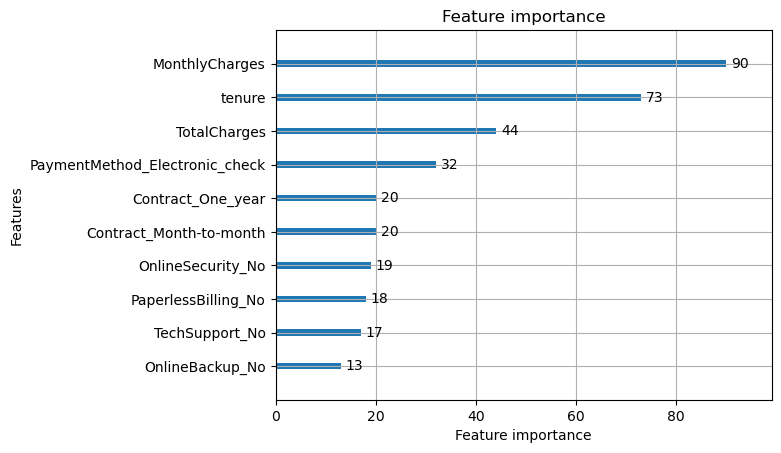

In [30]:
final_clf_lgb = LGBMClassifier(random_state=0, verbose=-1, **lgb_cv.best_params_)
final_clf_lgb.fit(X_train, y_train)

lgb.plot_importance(final_clf_lgb, max_num_features=10)
plt.show()

Monthly charge is the strongest predictor of customer churn. This agrees with what we saw in the boxplots. Does this mean we need to restructure our services and promote lower-priced service plans? On the other hand, it is possible that we get more profit from the high-paying customers even with their relatively high churn rate. Without profit information we will not be able to answer this question today, but this is definitely worth looking into. 

#### Confusion matrix

confusion matrix in training dataset
[[3790  343]
 [ 670  831]]


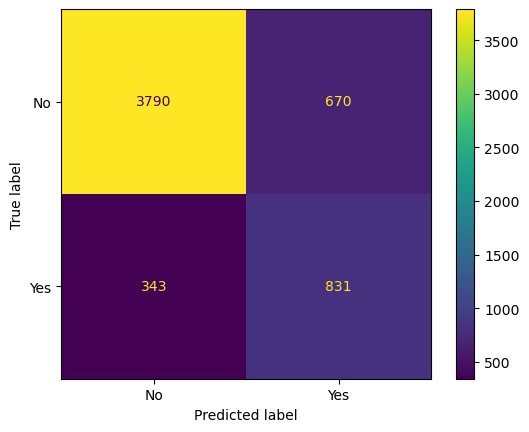

confusion matrix in testing dataset
[[942  99]
 [190 178]]


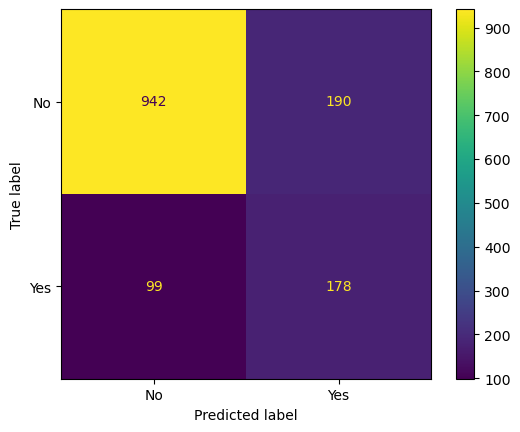

In [31]:
print('confusion matrix in training dataset')
print(confusion_matrix(y_train, lgb_cv.predict(X_train)))
ConfusionMatrixDisplay.from_predictions(lb.inverse_transform(lgb_cv.predict(X_train)), lb.inverse_transform(y_train))
plt.show()
print('confusion matrix in testing dataset')
print(confusion_matrix(y_test, lgb_cv.predict(X_test)))
ConfusionMatrixDisplay.from_predictions(lb.inverse_transform(lgb_cv.predict(X_test)), lb.inverse_transform(y_test))
plt.show()

### Model performance discussion

The tuned LightGBM model has multiple performance metrics that are similar between the training and testing datasets, indicating that the model is not overfitting. 

The accuracy and AUC scores are both ~0.8, suggesting reasonable performance.

However, the recall score in test data is 0.4837, meaning that we are identifying less than half of the customers that actually churned. This would be concerning when we build our customer retention program.

### Summary

We have developed a LightGBM classification model to predict customer churn. In a dataset that the model has not seen during training, our final model achieves a recall score of 0.4837, an accuracy score of 0.7949, and an AUC of 0.8325.

## Discussion and Conclusion

### Learning and takeaways

* We have identified some customer attributes that appear to lead to customer churn, such as having fiber optic internet service. We need to make business actions evaluating these services we offer and potentially initiate internal quality improvement programs. 
* At an individual level we have identified that customers that have high charges are likely to leave. One way to prevent churn is to constantly monitor customers' monthly bills and total charges, and potentially offer discounts to them if we predict they are about to churn. 
* Other factors also contribute to customer churn even though they may not warrant developing a full-fledged customer retention program to address them. We recommend communicating our findings regarding payment methods with the corresponding engineer team; the engineers may find ways to improve user experience when paying with electronic checks. We also recommend communicating the finding on paperless billing with marketing team - perhaps the marketing team will take actions to promote paperless billing sign-up. 

### Why recall is low

The recall score of our final model is rather low. This is likely due to the fact that the categorical variables do not interestingly distinguish between the churned and retained customers. If we examine the bar charts between the categorical features and the target. We often observe that, within each level of a categorical variable, the difference between the counts of churned and retained customers are large; however, across different levels of a categorical variable, the difference between the aforementioned differences is small. When we observe this, we would not expect the variable to significantly contribute to the prediction. 

### Ways to improve

Intuitively, we expect some features to have an synergistic effect. The first thing to try to improve the model is to create interaction features. 

In addition, we have discussed that the categorical variables do not demonstrate strong predictive capability. We can also gather more customer data, particularly data that reflect different aspects of a customer. For example, information on demographics and service subscribed is available in this dataset, prompting that the next step we can take is to gather customer usage of services they have subscribed. Intuitively, decreased usage is a good hint that a customer will completely stop using the service.

## Project Repository

This analysis is hosted at: https://github.com/EnergizeStatistics/csca5622week7/